### Importing Libraries

In [1]:
import numpy as np      #To perform operations on array
import cv2
import math
from PIL import Image

### Mean Calculation

In [2]:
# Calculates mean column-wise
# input -> mxn matrix
# output -> 1xn matrix
def mean_0(X):
    # Calculates mean of each column
    m,n = X.shape
    sums = np.full([1,n],0)
    for row in X:
        sums += row
    return sums/m

### Covariance Calculation

In [3]:
# Calculates the covariance 
# input -> a matrix mxn
# output -> covariance matrix nxn
def calcCov(x, y):
    mean_x, mean_y = x.mean(), y.mean()
    n = len(x)
    return sum((x - mean_x) * (y - mean_y)) / n
def cov(data):
    rows, cols = data.shape
    cov_mat = np.zeros((cols, cols))
    for i in range(cols):
        for j in range(cols):
            cov_mat[i][j] = calcCov(data[:, i], data[:, j])
    return cov_mat

### Mahalanobis Distance

In [4]:
# Calculates Mahalanobis distance between 2 points
# inputs -> 2 points p1, p2; inverse matrix X
# output -> scalar distance
def mahalanobis_distance(p1,p2,X): #p1 is model, p2 is the test point
    # X is inverse cov matrix
    distance = np.dot(np.dot(np.subtract(p2,p1),np.array(X)),np.subtract(p2,p1).T)
    return distance

### Loading Images

In [5]:
# Load 4 band images of 512x512 
imglist = 'band1.jpg', 'band2.jpg', 'band3.jpg','band4.jpg'
band_img = []
# Load in the images
for img in imglist:
    band_img.append(cv2.imread(img,0))

In [6]:
np.array(band_img).shape

(4, 512, 512)

### Training Coordinates

In [7]:
# Loads train 50 coordinates of River Class
df1 = np.genfromtxt('River', delimiter=',',dtype=int)
# Loads train 100 coordinates of Non-River Class
df2 = np.genfromtxt('NonRiver',  delimiter=',',dtype=int)

### Training Data

In [8]:
# Gets the coordinates and return the pixel value
# Inputs -> image(512x512x4); XY containing n coordinates
# Output -> np.array X_train nx4
def get_dataset(img,XY):
    X_train = []
    for band in img:
        ls=[band[x[1]][x[0]] for x in XY]
        X_train.append(ls)
    return np.array(X_train).T

#### River Dataset

In [9]:
# Get the 50 pixel values of river class for training
river_train = get_dataset(band_img,df1)
river_train.shape

(50, 4)

#### Non-River Dataset

In [10]:
# Get the 100 pixel values of non-river class for training
nonriver_train = get_dataset(band_img,df2)
nonriver_train.shape

(100, 4)

### Mean

In [11]:
# Mean of River Class
river_mean = mean_0(river_train)
# Mean of Non-River Class
nonriver_mean = mean_0(nonriver_train)

In [12]:
river_mean.shape

(1, 4)

### Covariance Matrix

In [13]:
#Covariance Matrix of River Class
river_cov = cov(river_train)
river_cov

array([[ 0.5876,  0.1836,  0.0904, -0.1764],
       [ 0.1836,  0.4196,  0.1344, -0.1604],
       [ 0.0904,  0.1344,  0.3616,  0.0144],
       [-0.1764, -0.1604,  0.0144,  0.4196]])

In [14]:
#Covariance Matrix of Non-River Class
nonriver_cov = cov(nonriver_train)
nonriver_cov

array([[ 7.2419,  5.8881,  8.6775,  1.8792],
       [ 5.8881,  6.2819,  8.9125,  4.4308],
       [ 8.6775,  8.9125, 17.0475,  4.57  ],
       [ 1.8792,  4.4308,  4.57  , 34.3056]])

In [15]:
# test_data is the 4 band images of 512x512
# Transposing the test_data so as to make it 512x512x4 (for ease of processing)
test_data = np.array(band_img).T
test_data.shape

(512, 512, 4)

### Bayes Classifier

#### Density function Class C
>$ \large P(x_i|y)=\frac{1}{\sqrt{|Cov_C|}} exp({-0.5*C}) $

#### Baye’s rule
$Class_1\hspace{2mm}  if \hspace{2mm} (P1 * p1) >= (P2 * p2)\\
else\hspace{2mm} Class_2$

In [16]:
# Calculates the output image pixel values for the given Prior prob
# Inputs -> Prior prob P1,P2; Mean of both classes mean_river, mean_nonriver; 
#           Covariance matrices of both classes river_cov, nonriver_cov; test_data 512x512x4
# Output -> Output image pixel value matrix 512x512
def bayes(P1, P2, mean_river, mean_nonriver, river_cov, nonriver_cov, test_data):
    X = np.linalg.inv(river_cov)
    Y = np.linalg.inv(nonriver_cov)
    m,n,p = test_data.shape
    Out_image = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            river_class =  mahalanobis_distance(mean_river,test_data[i][j],X)
            nonriver_class =  mahalanobis_distance(mean_nonriver,test_data[i][j],Y)
            p1 = (1/(np.linalg.det(river_cov)**0.5))*math.exp(-0.5*river_class)
            p2 = (1/(np.linalg.det(nonriver_cov)**0.5))*math.exp(-0.5*nonriver_class)
            
            if(P1*p1 >= P2*p2):
                Out_image[i][j] = 255
            else:
                Out_image[i][j] = 0
    return Out_image.T    

### Case 1 : River class (Prior Prob: ) = 0.3 , Nonriver class(Prior Prob) = 0.7

In [17]:
P1 = 0.3
P2 = 0.7
Out_image = bayes(P1,P2, river_mean, nonriver_mean, river_cov, nonriver_cov, test_data)
# Using Image from PIL, convert the Out_Image to image
# Image.fromarray -> Creates an image memory from an object exporting the array interface (using the buffer protocol)
im1 = Image.fromarray(np.uint8(Out_image))
im1.save("Output_Images/river03non07.jpeg")

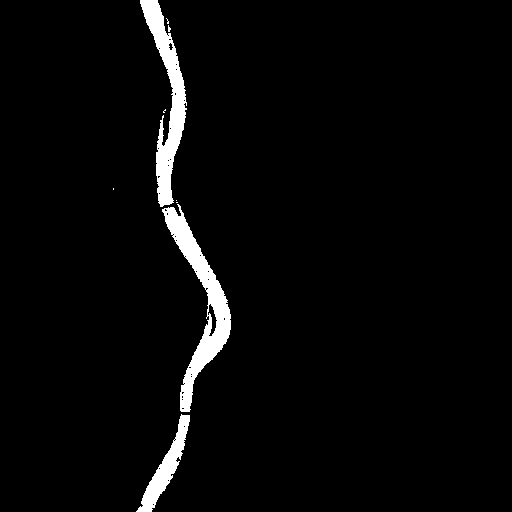

In [18]:
display(im1)

### Case 2 : River class (Prior Prob: ) = 0.7 , Nonriver class(Prior Prob) = 0.3

In [19]:
P1 = 0.7
P2 = 0.3
Out_image = bayes(P1,P2, river_mean, nonriver_mean, river_cov, nonriver_cov, test_data)
im2 = Image.fromarray(np.uint8(Out_image))

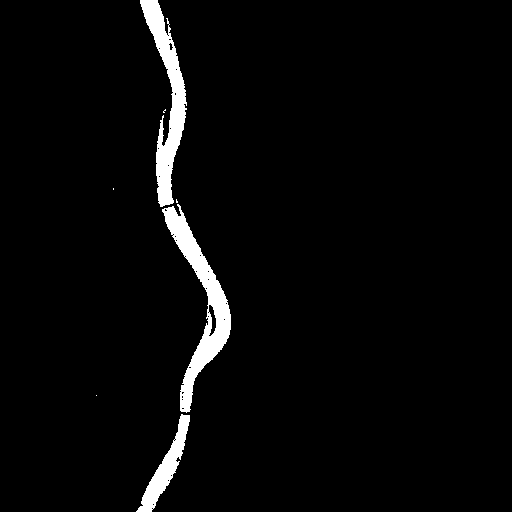

In [20]:
im2.save("Output_Images/river07non03.jpeg")
display(im2)

### Case 3 : River class (Prior Prob: ) = 0.5 , Nonriver class(Prior Prob) = 0.5

In [21]:
P1 = 0.5
P2 = 0.5
Out_image = bayes(P1,P2, river_mean, nonriver_mean, river_cov, nonriver_cov, test_data)
im3 = Image.fromarray(np.uint8(Out_image))
im3.save("Output_Images/river05non05.jpeg")

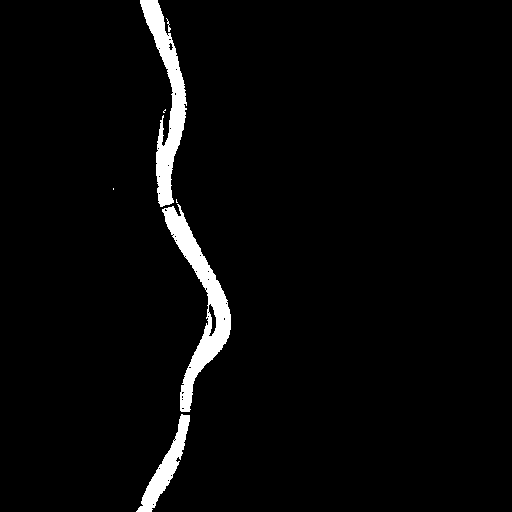

In [22]:
display(im3)